# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="Manual-implementation-of-the-Mersenne-twister-PseudoRandom-Number-Generator-(PRNG)-1" href="#Manual-implementation-of-the-Mersenne-twister-PseudoRandom-Number-Generator-(PRNG)"><span class="toc-item-num">1&nbsp;&nbsp;</span>Manual implementation of the Mersenne twister PseudoRandom Number Generator (PRNG)</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Common-API-for-the-PRNG-defined-here-11" href="#Common-API-for-the-PRNG-defined-here"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Common API for the PRNG defined here</a></div><div class="lev2 toc-item"><a data-toc-modified-id="First-example:-a-simple-linear-congruential-generator-12" href="#First-example:-a-simple-linear-congruential-generator"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>First example: a simple linear congruential generator</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Checking-and-plotting-the-result?-13" href="#Checking-and-plotting-the-result?"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Checking and plotting the result?</a></div><div class="lev2 toc-item"><a data-toc-modified-id="A-second-example:-Multiple-Recursive-Generator-14" href="#A-second-example:-Multiple-Recursive-Generator"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>A second example: Multiple-Recursive Generator</a></div><div class="lev2 toc-item"><a data-toc-modified-id="A-third-example:-combined-Multiple-Recursive-Generator,-with-MRG32k3a-15" href="#A-third-example:-combined-Multiple-Recursive-Generator,-with-MRG32k3a"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>A third example: combined Multiple-Recursive Generator, with <code>MRG32k3a</code></a></div><div class="lev2 toc-item"><a data-toc-modified-id="Finally,-the-Mersenne-twister-PRNG-16" href="#Finally,-the-Mersenne-twister-PRNG"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Finally, the Mersenne twister PRNG</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Period-161" href="#Period"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Period</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Random-seeds-162" href="#Random-seeds"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Random seeds</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Implementing-the-Mersenne-twister-algorithm-163" href="#Implementing-the-Mersenne-twister-algorithm"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Implementing the Mersenne twister algorithm</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Small-review-of-bitwise-operations-164" href="#Small-review-of-bitwise-operations"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span>Small review of bitwise operations</a></div><div class="lev3 toc-item"><a data-toc-modified-id="Testing-our-implementation-165" href="#Testing-our-implementation"><span class="toc-item-num">1.6.5&nbsp;&nbsp;</span>Testing our implementation</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Conclusion-17" href="#Conclusion"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Conclusion</a></div>

# Manual implementation of the Mersenne twister PseudoRandom Number Generator (PRNG)
This small notebook is a short experiment, to see if I can implement an the Manual implementation of the [Mersenne twister](https://en.wikipedia.org/wiki/Mersenne_twister) PseudoRandom Number Generator ([PRNG](https://en.wikipedia.org/wiki/Pseudo-random_number_generator)).

- *Reference*: [Wikipedia](https://en.wikipedia.org/wiki/Mersenne_twister), and this book: ["Simulation and the Monte-Carlo method", by R.Y.Rubinstein & D.P.Kroese](http://www.wiley.com/WileyCDA/WileyTitle/productCd-1118632168.html) ([Rubinstein & Kroese, 2017]), chapter 2 pages 52-53.
- *Date*: 11 March 2017.
- *Author*: [Lilian Besson](https://GitHub.com/Naereen/notebooks).
- *License*: [MIT Licensed](https://lbesson.mit-license.org/).

----

## Common API for the PRNG defined here
First, I want to define a simple object-oriented API, in order to write all the examples of PNRG with the same interface.

In [47]:
import numpy as np

In [48]:
class PRNG(object):
    """Base class for any Pseudo-Random Number Generator."""
    def __init__(self, X0=0):
        """Create a new PRNG with seed X0."""
        self.X0 = X0
        self.X = X0
        self.t = 0
        self.max = 0
    
    def __iter__(self):
        """self is already an iterator!"""
        return self
    
    def seed(self, X0=None):
        """Reinitialize the current value with X0, or self.X0.
        
        - Tip: Manually set the seed if you need reproducibility in your results.
        """
        self.t = 0
        self.X = self.X0 if X0 is None else X0
    
    def __next__(self):
        """Produce a next value and return it."""
        # This default PRNG does not produce random numbers!
        self.t += 1
        return self.X
    
    def randint(self, *args, **kwargs):
        """Return an integer number in [| 0, self.max - 1 |] from the PRNG."""
        return self.__next__()

    def int_samples(self, shape=(1,)):
        """Get a numpy array, filled with integer samples from the PRNG, of shape = shape."""
        # return [ self.randint() for _ in range(size) ]
        return np.fromfunction(np.vectorize(self.randint), shape=shape, dtype=int)

    def rand(self, *args, **kwargs):
        """Return a float number in [0, 1) from the PRNG."""
        return self.randint() / float(1 + self.max)

    def float_samples(self, shape=(1,)):
        """Get a numpy array, filled with float samples from the PRNG, of shape = shape."""
        # return [ self.rand() for _ in range(size) ]
        return np.fromfunction(np.vectorize(self.rand), shape=shape, dtype=int)

----
## First example: a simple linear congruential generator
Let me start by implementing a simple linear congruential generator, with three parameters $m$, $a$, $c$, defined like this :

- Start from $X_0$,
- And then follow the recurrence equation: $$ X_{t+1} = (a X_t + c) \mod m. $$

This algorithm produces a sequence $(X_t)_{t\in\mathbb{N}} \in \mathbb{N}^{\mathbb{N}}$.

In [49]:
class LinearCongruentialGenerator(PRNG):
    """A simple linear congruential Pseudo-Random Number Generator."""
    def __init__(self, m, a, c, X0=0):
        """Create a new PRNG with seed X0."""
        super(LinearCongruentialGenerator, self).__init__(X0=X0)
        self.m = self.max = m
        self.a = a
        self.c = c
    
    def __next__(self):
        """Produce a next value and return it, following the recurrence equation: X_{t+1} = (a X_t + c) mod m."""
        self.t += 1
        x = self.X
        self.X = (self.a * self.X + self.c) % self.m
        return x

The values recommended by the authors, Lewis, Goodman and Miller, are the following:

In [50]:
m = 1 << 31 - 1  # 1 << 31 = 2**31
a = 7 ** 4
c = 0

The seed is important. If $X_0 = 0$, this first example PRNG will only produce $X_t = 0, \forall t$.

In [51]:
FirstExample = LinearCongruentialGenerator(m=m, a=a, c=c)

In [52]:
def test(example, nb=3):
    for t, x in enumerate(example):
        print("{:>3}th value for {.__class__.__name__} is X_t = {:>10}".format(t, example, x))
        if t >= nb - 1:
            break

In [54]:
test(FirstExample)

  0th value for LinearCongruentialGenerator is X_t =          0
  1th value for LinearCongruentialGenerator is X_t =          0
  2th value for LinearCongruentialGenerator is X_t =          0


But with any positive seed, the sequence will appear random.

In [55]:
SecondExample = LinearCongruentialGenerator(m=m, a=a, c=c, X0=12011993)

In [56]:
test(SecondExample)

  0th value for LinearCongruentialGenerator is X_t =   12011993
  1th value for LinearCongruentialGenerator is X_t =  923507769
  2th value for LinearCongruentialGenerator is X_t =   65286809


The sequence is completely determined by the seed $X_0$:

In [57]:
SecondExample.seed(12011993)
test(SecondExample)

  0th value for LinearCongruentialGenerator is X_t =   12011993
  1th value for LinearCongruentialGenerator is X_t =  923507769
  2th value for LinearCongruentialGenerator is X_t =   65286809


> Note: I prefer to use this custom class to define iterators, instead of a simple generator (with `yield` keyword) as I want them to have a `.seed(X0)` method.

----
## Checking and plotting the result?
First, we can generate a matrix of samples, as random floats in $[0, 1)$, and check that the mean is about $1/2$:

In [58]:
shape = (400, 400)
image = SecondExample.float_samples(shape)

In [59]:
np.mean(image), np.var(image)

(0.4996821506033815, 0.083393476821803994)

What about the speed? Of course, a hand-written Python code will always be really slower than a C-extension code, and the PRNG from the modules `random` or `numpy.random` are written in C (or Cython), and so will always be faster.
But how much faster?

In [60]:
import random
import numpy.random

print(np.mean(SecondExample.float_samples(shape)))
print(np.mean([ [ random.random() for _ in range(shape[0]) ] for _ in range(shape[1]) ]))
print(np.mean(numpy.random.random(shape)))

0.500181275654
0.499571574066
0.500195895272


In [61]:
%timeit SecondExample.float_samples(shape)
%timeit [ [ random.random() for _ in range(shape[0]) ] for _ in range(shape[1]) ]
%timeit numpy.random.random(shape)

1 loop, best of 3: 466 ms per loop
10 loops, best of 3: 41.5 ms per loop
100 loops, best of 3: 3.34 ms per loop


That's a very satisfying result: of course `numpy.random.` functions are written and optimized to generate thousands of samples quickly, and of course my hand-written Python implementation for `LinearCongruentialGenerator` is slower than the C-code generating the module `random`.

----
We can also plot this image as a grayscaled image, in order to visualize this "randomness" we just created.

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

def showimage(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

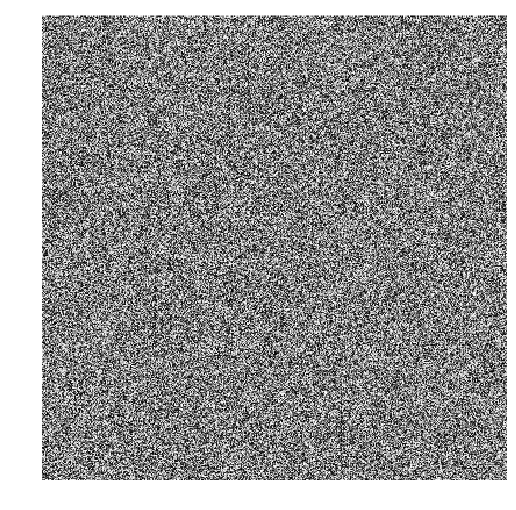

In [63]:
showimage(image)

It looks good already! We can't see any recurrence, but we see a regularity, with small squares.

And it does not seem to depend too much on the seed:

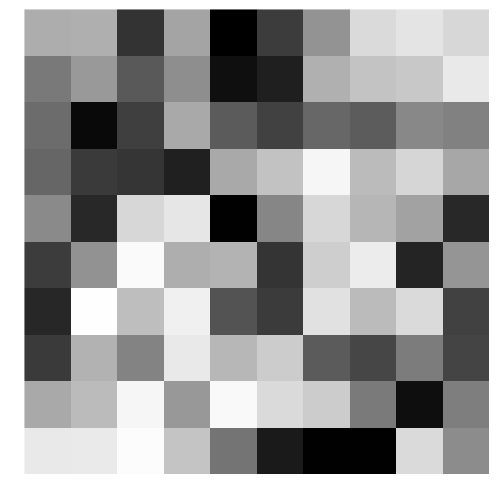

In [64]:
SecondExample.seed(11032017)
image = SecondExample.float_samples((10, 10))
showimage(image)

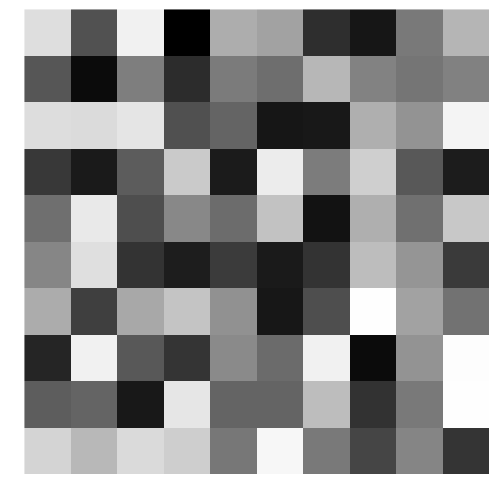

In [65]:
SecondExample.seed(1103201799)
image = SecondExample.float_samples((10, 10))
showimage(image)

We can also visualize the generated numbers with a histogram, to visually check that the random numbers in $[0, 1)$ are indeed "uniformly" located.

In [171]:
def plotHistogram(example, nb=100000, bins=200):
    numbers = example.float_samples((nb,))
    plt.figure(figsize=(14, 3))
    plt.hist(numbers, bins=bins, normed=True, alpha=0.8)
    plt.xlabel("Random numbers in $[0, 1)$")
    plt.ylabel("Mass repartition")
    plt.title("Repartition of ${}$ random numbers in $[0, 1)$".format(nb))
    plt.show()

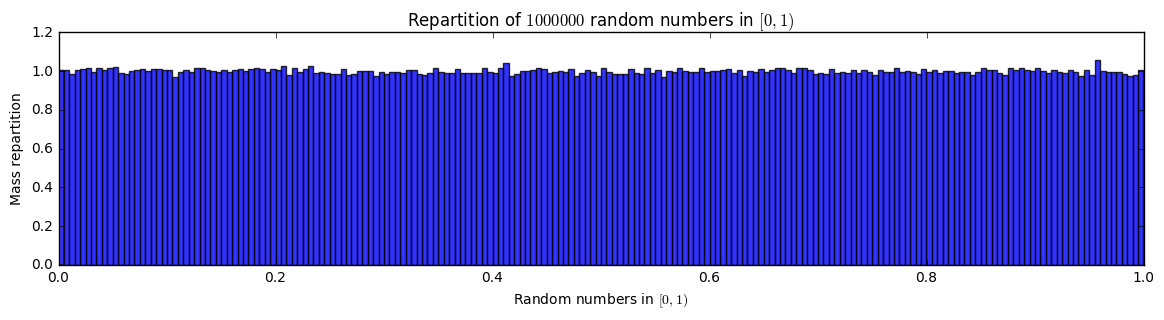

In [172]:
plotHistogram(SecondExample, 1000000, 200)

----
## A second example: Multiple-Recursive Generator
Let start by writing a generic Multiple Recursive Generator, which is defined by the following linear recurrence equation, of order $k \geq 1$:

- Start from $X_0$, with a false initial history of $(X_{-k+1}, X_{-k}, \dots, X_{-1})$,
- And then follow the recurrence equation: $$ X_{t} = (a_1 X_{t-1} + \dots + a_k X_{t-k}) \mod m. $$

This algorithm produces a sequence $(X_t)_{t\in\mathbb{N}} \in \mathbb{N}^{\mathbb{N}}$.

In [66]:
class MultipleRecursiveGenerator(PRNG):
    """A Multiple Recursive Pseudo-Random Number Generator (MRG), with one sequence (X_t)."""
    def __init__(self, m, a, X0):
        """Create a new PRNG with seed X0."""
        assert np.shape(a) == np.shape(X0), "Error: the weight vector a must have the same shape as X0."
        super(MultipleRecursiveGenerator, self).__init__(X0=X0)
        self.m = self.max = m
        self.a = a
    
    def __next__(self):
        """Produce a next value and return it, following the recurrence equation: X_t = (a_1 X_{t-1} + ... + a_k X_{t-k}) mod m."""
        self.t += 1
        x = self.X[0]
        nextx = (np.dot(self.a, self.X)) % self.m
        self.X[1:] = self.X[:-1]
        self.X[0] = nextx
        return x

For example, with an arbitrary choice of $k = 3$, of weights $a = [10, 9, 8]$ and $X_0 = [10, 20, 30]$:

In [69]:
m = (1 << 31) - 1
X0 = np.array([10, 20, 30])
a = np.array([10, 9, 8])

ThirdExample = MultipleRecursiveGenerator(m, a, X0)

test(ThirdExample)

  0th value for MultipleRecursiveGenerator is X_t =         10
  1th value for MultipleRecursiveGenerator is X_t =        520
  2th value for MultipleRecursiveGenerator is X_t =       5450


We can again check for the mean and the variance of the generated sequence:

In [70]:
shape = (400, 400)
image = ThirdExample.float_samples(shape)
np.mean(image), np.var(image)

(0.49978538707846892, 0.08323292202789713)

This Multiple Recursive Generator is of course slower than the simple Linear Recurrent Generator:

In [71]:
%timeit SecondExample.float_samples(shape)
%timeit ThirdExample.float_samples(shape)

1 loop, best of 3: 479 ms per loop
1 loop, best of 3: 3.27 s per loop


And it seems to work fine as well:

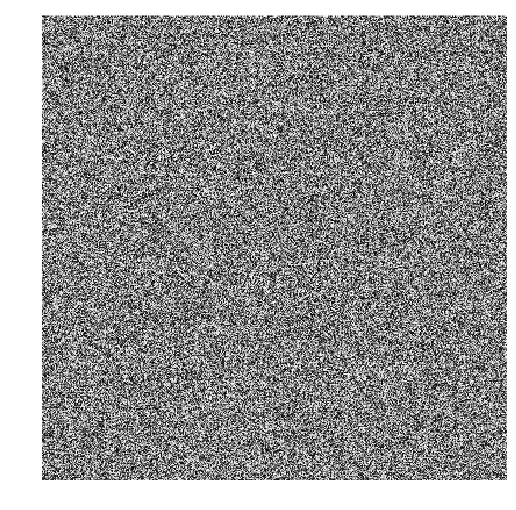

In [72]:
showimage(image)

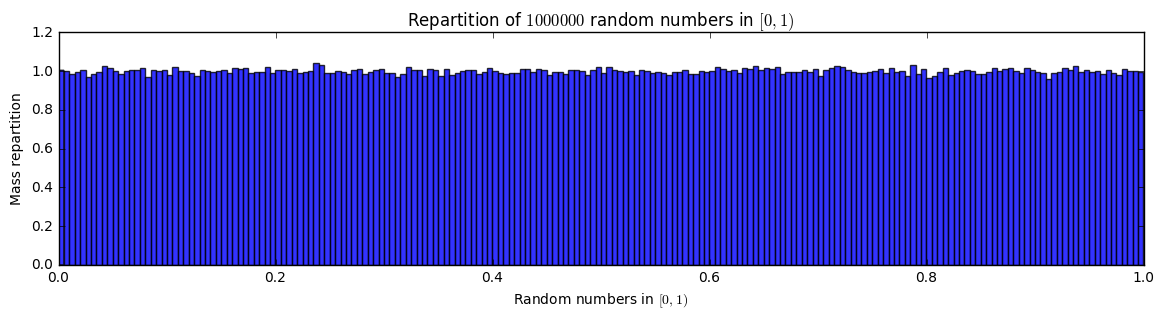

In [173]:
plotHistogram(ThirdExample, 1000000, 200)

> It looks also good!

----
## A third example: combined Multiple-Recursive Generator, with `MRG32k3a`

Let start by writing a generic Multiple Recursive Generator, which is defined by the following coupled linear recurrence equation, of orders $k_1, k_2 \geq 1$:

- Start from $X_0$ and $Y_0$, with a false initial history of $(X_{-k_1 + 1}, X_{-k_1}, \dots, X_{-1})$ and $(Y_{-k_2 + 1}, Y_{-k_2}, \dots, Y_{-1})$,
- And then follow the recurrence equation: $$ X_{t} = (a_1 X_{t-1} + \dots + a_{k_1} X_{t-k_1}) \mod m. $$ and $$ Y_{t} = (b_1 Y_{t-1} + \dots + b_{k_2} Y_{t-k_2}) \mod m. $$

This algorithm produces two sequences $(X_t)_{t\in\mathbb{N}} \in \mathbb{N}^{\mathbb{N}}$ and $(X_t)_{t\in\mathbb{N}} \in \mathbb{N}^{\mathbb{N}}$, and usually the sequence used for the output is $U_t = X_t - Y_t + \max(m_1, m_2)$.

In [74]:
class CombinedMultipleRecursiveGenerator(PRNG):
    """A Multiple Recursive Pseudo-Random Number Generator (MRG), with two sequences (X_t, Y_t)."""
    def __init__(self, m1, a, X0, m2, b, Y0):
        """Create a new PRNG with seeds X0, Y0."""
        assert np.shape(a) == np.shape(X0), "Error: the weight vector a must have the same shape as X0."
        assert np.shape(b) == np.shape(Y0), "Error: the weight vector b must have the same shape as Y0."
        self.t = 0
        # For X
        self.m1 = m1
        self.a = a
        self.X0 = self.X = X0
        # For Y
        self.m2 = m2
        self.b = b
        self.Y0 = self.Y = Y0
        # Maximum integer number produced is max(m1, m2)
        self.m = self.max = max(m1, m2)
    
    def __next__(self):
        """Produce a next value and return it, following the recurrence equation: X_t = (a_1 X_{t-1} + ... + a_k X_{t-k}) mod m."""
        self.t += 1
        # For X
        x = self.X[0]
        nextx = (np.dot(self.a, self.X)) % self.m1
        self.X[1:] = self.X[:-1]
        self.X[0] = nextx
        # For Y
        y = self.Y[0]
        nexty = (np.dot(self.b, self.Y)) % self.m2
        self.Y[1:] = self.Y[:-1]
        self.Y[0] = nexty
        # Combine them
        u = x - y + (self.m1 if x <= y else 0)
        return u

To obtain the well-known `MRG32k3a` generator, designed by L'Ecuyer in 1999, we chose these parameters:

In [76]:
m1 = (1 << 32) - 209                  # important choice!
a = np.array([0, 1403580, -810728])   # important choice!
X0 = np.array([1000, 10000, 100000])  # arbitrary choice!

m2 = (1 << 32) - 22853                # important choice!
b = np.array([527612, 0, -1370589])   # important choice!
Y0 = np.array([5000, 50000, 500000])  # arbitrary choice!

MRG32k3a = CombinedMultipleRecursiveGenerator(m1, a, X0, m2, b, Y0)

test(MRG32k3a)

  0th value for CombinedMultipleRecursiveGenerator is X_t = 4294963087
  1th value for CombinedMultipleRecursiveGenerator is X_t = 1442746955
  2th value for CombinedMultipleRecursiveGenerator is X_t =  970596549


We can again check for the mean and the variance of the generated sequence:

In [77]:
shape = (400, 400)
image = MRG32k3a.float_samples(shape)
np.mean(image), np.var(image)

(0.50116948407748341, 0.083189188379866608)

This combined Multiple Recursive Generator is of course slower than the simple Multiple Recursive Generator and the simple Linear Recurrent Generator:

In [78]:
%timeit SecondExample.float_samples(shape)
%timeit ThirdExample.float_samples(shape)
%timeit MRG32k3a.float_samples(shape)

1 loop, best of 3: 557 ms per loop
1 loop, best of 3: 3.32 s per loop
1 loop, best of 3: 4.2 s per loop


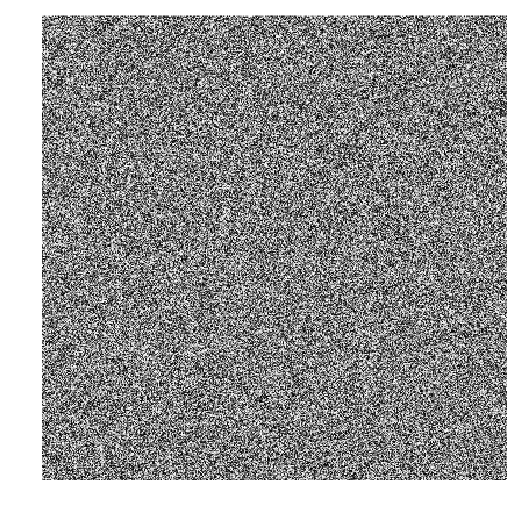

In [80]:
showimage(image)

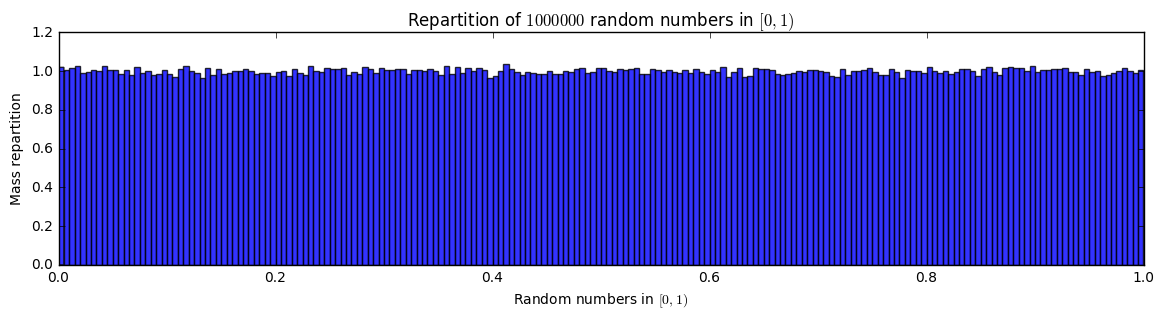

In [174]:
plotHistogram(MRG32k3a, 1000000, 200)

> This one looks fine too!

----
## Finally, the Mersenne twister PRNG

I won't explain all the details, and will follow closely the notations from my reference book [Rubinstein & Kroese, 2017].
It will be harder to implement!

First, let us compute the period of the PRNG we will implement, with the default values for the parameters $w = 32$ (word length) and $n = 624$ ("big" integer).

### Period

In [140]:
w = 32
n = 624

In [141]:
def MersenneTwisterPeriod(n, w):
    return (1 << (w * (n - 1) + 1)) - 1

MersenneTwisterPeriod(n, w) == (2 ** 19937) - 1

True

### Random seeds
Then we need to use a previously defined PRNG to set the random seeds.

In [142]:
def seed_rows(example, n, w):
    return example.int_samples((n,))

def random_Mersenne_seed(n, w):
    assert w == 32, "Error: only w = 32 was implemented"
    m1 = (1 << 32) - 209                  # important choice!
    a = np.array([0, 1403580, -810728])   # important choice!
    X0 = np.array([1000, 10000, 100000])  # arbitrary choice!
    m2 = (1 << 32) - 22853                # important choice!
    b = np.array([527612, 0, -1370589])   # important choice!
    Y0 = np.array([5000, 50000, 500000])  # arbitrary choice!
    MRG32k3a = CombinedMultipleRecursiveGenerator(m1, a, X0, m2, b, Y0)
    seed = seed_rows(MRG32k3a, n, w)
    assert np.shape(seed) == (n,)
    return seed

example_seed = random_Mersenne_seed(n, w)
example_seed

array([1442746955,  970596549, 1424553282, 3434382594, 2719809908,
        907257579, 3366949065, 3993861444, 3011195972, 2360801572,
       4218769233, 3311478775,  814078105, 4247319135,  135985431,
       2977131088, 2135064797,  174993674, 2919031450, 1491961017,
       1282531088,  395762067, 1438677151, 1404204802, 1615198627,
       3981385519, 4066724105, 2111642828, 2185959254,  169427307,
       2244038195, 1394850803,  570739999, 3278314025,  613130969,
       1439103195, 3840619526, 2498230089, 2057143171, 3548138318,
       1869242945, 2556940784, 3447429700, 2468977043, 3303523212,
       2896901380, 2238557874,  528153848, 4034993136, 2131766206,
        592974503, 2369741853, 1731300735,  644826481,  773985738,
       1099277721, 1618421052, 3491381544,  552581740,  724062011,
        891136537,  260818674,  616571943, 3951006091, 2043450847,
        935700878, 2789774205, 2100429622, 1228002137, 4076512004,
       2724482467, 1218661147,   69019331, 3063859178,  852736

In [143]:
for xi in example_seed:
    print("Integer xi = {:>12} and in binary, bin(xi) = {:>34}".format(xi, bin(xi)))

Integer xi =   1442746955 and in binary, bin(xi) =  0b1010101111111101001001001001011
Integer xi =    970596549 and in binary, bin(xi) =   0b111001110110100010000011000101
Integer xi =   1424553282 and in binary, bin(xi) =  0b1010100111010001111010101000010
Integer xi =   3434382594 and in binary, bin(xi) = 0b11001100101101001000010100000010
Integer xi =   2719809908 and in binary, bin(xi) = 0b10100010000111010000000101110100
Integer xi =    907257579 and in binary, bin(xi) =   0b110110000100111010011011101011
Integer xi =   3366949065 and in binary, bin(xi) = 0b11001000101011111001000011001001
Integer xi =   3993861444 and in binary, bin(xi) = 0b11101110000011010111110101000100
Integer xi =   3011195972 and in binary, bin(xi) = 0b10110011011110110011010001000100
Integer xi =   2360801572 and in binary, bin(xi) = 0b10001100101101101111100100100100
Integer xi =   4218769233 and in binary, bin(xi) = 0b11111011011101010100111101010001
Integer xi =   3311478775 and in binary, bin(xi) = 0b1

### Implementing the Mersenne twister algorithm
Finally, the Mersenne twister can be implemented like this:

In [176]:
class MersenneTwister(PRNG):
    """The Mersenne twister Pseudo-Random Number Generator (MRG)."""
    def __init__(self, seed,
                 w=32, n=624, m=397, r=31,
                 a=0x9908B0DF, b=0x9D2C5680, c=0xEFC60000,
                 u=11, s=7, v=15, l=18):
        """Create a new Mersenne twister PRNG with this seed."""
        self.t = 0
        # Parameters
        self.w = w
        self.n = n
        self.m = m
        self.r = r
        self.a = a
        self.b = b
        self.c = c
        self.u = u
        self.s = s
        self.v = v
        self.l = l
        # For X
        self.X0 = seed
        self.X = np.copy(seed)
        # Maximum integer number produced is 2**w - 1
        self.max = (1 << w) - 1
        
    def __next__(self):
        """Produce a next value and return it, following the Mersenne twister algorithm."""
        self.t += 1
        # 1. --- Compute x_{t+n}
        # 1.1.a. First r bits of x_t : left = (x_t >> r) << r
        # 1.1.b. Last w - r bits of x_{t+1} : right = x & ((1 << (w - r)) - 1)
        # 1.1.c. Concatenate them together in a binary vector x : x = left + right
        x = (( self.X[0] >> self.r) << self.r) + (self.X[1] & ((1 << (self.w - self.r)) - 1))
        xw = x % 2             # 1.2. get xw
        if xw == 0:
            xtilde = (x >> 1)            # if xw = 0, xtilde = (x >> 1)
        else:
            xtilde = (x >> 1) ^ self.a   # if xw = 1, xtilde = (x >> 1) ⊕ a
        nextx = self.X[self.m] ^ xtilde  # 1.3. x_{t+n} = x_{t+m} ⊕ \tilde{x}
        # 2. --- Shift the content of the n rows
        oldx0 = self.X[0]          # 2.a. First, forget x0
        self.X[:-1] = self.X[1:]   # 2.b. shift one index on the left, x1..xn-1 to x0..xn-2
        self.X[-1]  = nextx        # 2.c. write new xn-1
        # 3. --- Then use it to compute the answer, y
        y = nextx                      # 3.a. y = x_{t+n}
        y ^= (y >> self.u)             # 3.b. y = y ⊕ (y >> u)
        y ^= ((y << self.s) & self.b)  # 3.c. y = y ⊕ ((y << s) & b)
        y ^= ((y << self.v) & self.c)  # 3.d. y = y ⊕ ((y << v) & c)
        y ^= (y >> self.l)             # 3.e. y = y ⊕ (y >> l)
        return y

### Small review of bitwise operations

The Python documentation explains how to [use bitwise operations easily](https://docs.python.org/3/library/stdtypes.html?highlight=bitwise#bitwise-operations-on-integer-types), and also [this page](https://wiki.python.org/moin/BitwiseOperators) and [this StackOverflow answer](http://stackoverflow.com/a/1746642/).

The only difficult part of the algorithm is the first step, when we need to take the first $r$ bits of $X_t =$ `X[0]`, and the last $w - r$ bits of $X_{t+1} =$ `X[1]`.
On some small examples, let quickly check that I implemented this correctly:

In [151]:
def testsplit(x, r, w):
    assert x.bit_length() == w
    left = x >> r
    right = x & ((1 << (w - r)) - 1)
    x2 = (left << r) + right
    assert x == x2
    print("x = {} -> left r={} = {} and right w-r={} = {}".format(bin(x), r, bin(left), w-r, bin(right)))

x = 0b10011010
testsplit(x, r=4, w=x.bit_length())
x = 0b10010011
testsplit(x, r=4, w=x.bit_length())
x = 0b10011111
testsplit(x, r=4, w=x.bit_length())
x = 0b11110001
testsplit(x, r=4, w=x.bit_length())

x = 0b10011010 -> left r=4 = 0b1001 and right w-r=4 = 0b1010
x = 0b10010011 -> left r=4 = 0b1001 and right w-r=4 = 0b11
x = 0b10011111 -> left r=4 = 0b1001 and right w-r=4 = 0b1111
x = 0b11110001 -> left r=4 = 0b1111 and right w-r=4 = 0b1


### Testing our implementation

In [177]:
ForthExample = MersenneTwister(example_seed)

In [178]:
ForthExample.int_samples((10,))

array([1474867158, 2449700520,  474789807, 1902008470, 4128492956,
       2297861119,  879429558,  629294567, 1725730677, 4049086862])

We can again check for the mean and the variance of the generated sequence:

In [179]:
shape = (400, 400)
image = ForthExample.float_samples(shape)
np.mean(image), np.var(image)

(0.49959212309519646, 0.082454087629670478)

This Python hand-written Mersenne twister is of course slower than the previous PRNG defined above (combined Multiple Recursive Generator, simple Multiple Recursive Generator, and the simple Linear Recurrent Generator):

In [180]:
%timeit SecondExample.float_samples(shape)
%timeit ThirdExample.float_samples(shape)
%timeit MRG32k3a.float_samples(shape)
%timeit ForthExample.float_samples(shape)

1 loop, best of 3: 574 ms per loop
1 loop, best of 3: 3.26 s per loop
1 loop, best of 3: 5.17 s per loop
1 loop, best of 3: 4.9 s per loop


A good surprise is that this implementation Mersenne appears faster than the combined MRG of order $k = 3$ (i.e., `MRG32k3a`).

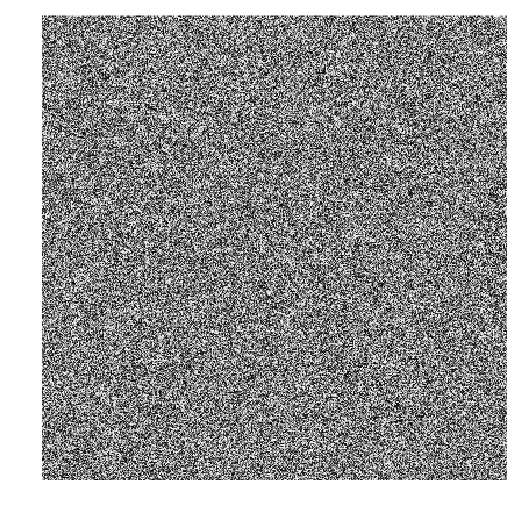

In [181]:
showimage(image)

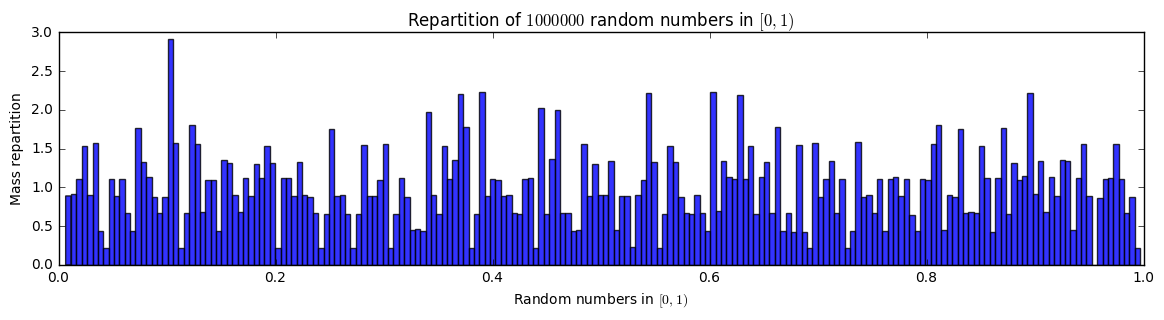

In [182]:
plotHistogram(ForthExample, 1000000, 200)

----
## Conclusion
Well, that's it, I just wanted to implement a few Pseudo-Random Number Generators, and compare them.

I should finish the job:
- implement a test for "randomness", and check the various PRNG I implemented against it,
- use these various `rand()` functions (uniform in $[0,1)$) to generate other distributions.